# Training patches preparation

In [1]:
import sys
sys.path.insert(0, "..")
import matplotlib.pyplot as plt
from PIL import Image
import json

from dataloader import *
from lib import *
from model import *

In [2]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\p.dyroey\Documents\GitHub\Moonrise-AI\notebooks


In [3]:
print(PATH_PARAMETERS)
with open(PATH_PARAMETERS) as f:
    params = json.load(f)
params = params['models_settings']
print(params)

../params_raupe.json
{'resize_width': 2000, 'equalize': 'True', 'patch_width': 500, 'patch_height': 500, 'label_to_value': {'_background_': 0, 'good': 1}, 'dir': '../data/', 'train_dir': 'moonrise2', 'test_dir': 'images_test', 'image_folder': 'images', 'mask_folder': 'masks'}


### Explore dataset

In [4]:
file_names = get_image_names()  
print(file_names)
labels = list_labels(file_names)
size_ranges = get_sizes(file_names)
print(f'labels in dataset : {labels}')
print(f'size ranges : {size_ranges}')

found 14 images
['../data/moonrise2\\images\\220920-1_Altes getrocknet_img.png', '../data/moonrise2\\images\\220920-2_Altes getrocknet_img.png', '../data/moonrise2\\images\\220921-1_800°getrocknet_img.png', '../data/moonrise2\\images\\220921-2_800°getrocknet_img.png', '../data/moonrise2\\images\\220921-3_800°getrocknet_img.png', '../data/moonrise2\\images\\220926-1_TUBS-T_800°C_10,1A_img.png', '../data/moonrise2\\images\\220926-2_TUBS-T_800°C_10,5A_img.png', '../data/moonrise2\\images\\220926-3_TUBS-T_800°C_11A_img.png', '../data/moonrise2\\images\\220926-6_Südpol_800°C_img.png', '../data/moonrise2\\images\\220926-7_Südpol_800°C_img.png', '../data/moonrise2\\images\\220926-8_Südpol_800°C_img.png', '../data/moonrise2\\images\\220928-5_PAS_300°C_img.png', '../data/moonrise2\\images\\220928-6_PAS_300°C_img.png', '../data/moonrise2\\images\\220928-7_PAS_300°C_img.png']
no masks: 14
labels in dataset : {'good', '_background_'}
size ranges : {'h-range': [996, 1230], 'w-range': [902, 1153]}


In [5]:
images = load_images(file_names)
masks = load_masks(file_names)

no images: 14
no masks: 14


image shape =  (2257, 2000, 4)
mask shape =  (2257, 2000)


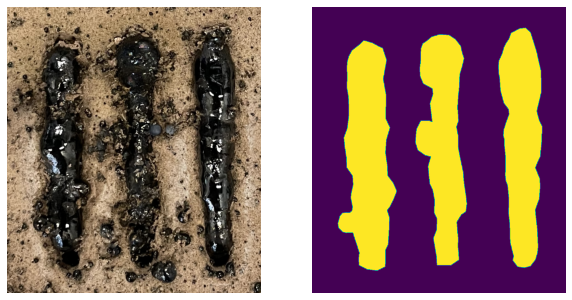

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(images[0], cmap='gray')
ax[0].axis('off')
ax[1].imshow(masks[0])
ax[1].axis('off')
print('image shape = ', images[0].shape)
print('mask shape = ', masks[0].shape)

### Patch extraction

In [7]:
# number of patches per image (should depend on patch and image size)
n = 20

shape_to_label = params['label_to_value']
label_to_shape = {v:k for k,v in shape_to_label.items()}
d_pixels = {k:0 for k in shape_to_label.keys()}
d_images = {k:0 for k in shape_to_label.keys()}
feature_labels = set([v for k,v in shape_to_label.items() if k!='_background_'])

data = []

for img,mask in zip(images,masks):
    #print(mask.shape)
    #print(len(mask.shape))
    # error but cant find the solution. the image is already 2d so no rgb2mask needed. but tests dont work 
    #mask = rgb2mask(mask)
    patches, patch_masks = random_patches(img, mask, n=n, patch_h=params['patch_height'], patch_w=params['patch_width'])
    for patch, patch_mask in zip(patches,patch_masks):
        # consider only patch containing feature_labels
        if len(set(np.unique(patch_mask)).intersection(feature_labels))>0:  
            data.append((patch, patch_mask))
            
            count = Counter(patch_mask.flatten().tolist())
            for label, num in count.most_common():
                d_pixels[label_to_shape[label]] += num
                d_images[label_to_shape[label]] += 1
                
print('pixel per class = ', d_pixels)
print('images per class = ', d_images)
                
data_aug = augment_rectangular(data)      
random.shuffle(data_aug)
    
F = [val/(d_images[key]*patch_mask.size) for key,val in d_pixels.items()]
w = np.median(F)/F
print('cross entropy loss class weights = ', w)

pixel per class =  {'_background_': 40439590, 'good': 27310410}
images per class =  {'_background_': 271, 'good': 271}
cross entropy loss class weights =  [0.83766922 1.24036951]


(500, 500, 4) (500, 500)


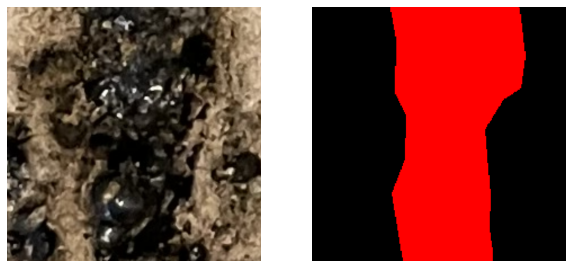

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(data[0][0], cmap='gray')
ax[0].axis('off')
ax[1].imshow(mask2rgb(data[0][1]))
ax[1].axis('off')
print(patch.shape, patch_mask.shape)

In [9]:
export_dir = f"{params['dir']}{params['train_dir']}_patches_{params['patch_width']}"
save_patches(export_dir, data_aug)

### Visualize patches

In [10]:
tile_size = (256, 128)

path_images = natsort.natsorted(glob(os.path.join(export_dir, 'images', '*.png')))
path_masks = natsort.natsorted(glob(os.path.join(export_dir, 'masks', '*.png')))

# fix plot to accept npy array input or save mask properl as an image
complete_image = compose_image(path_images, path_masks, tile_size, n=3)

0 1024


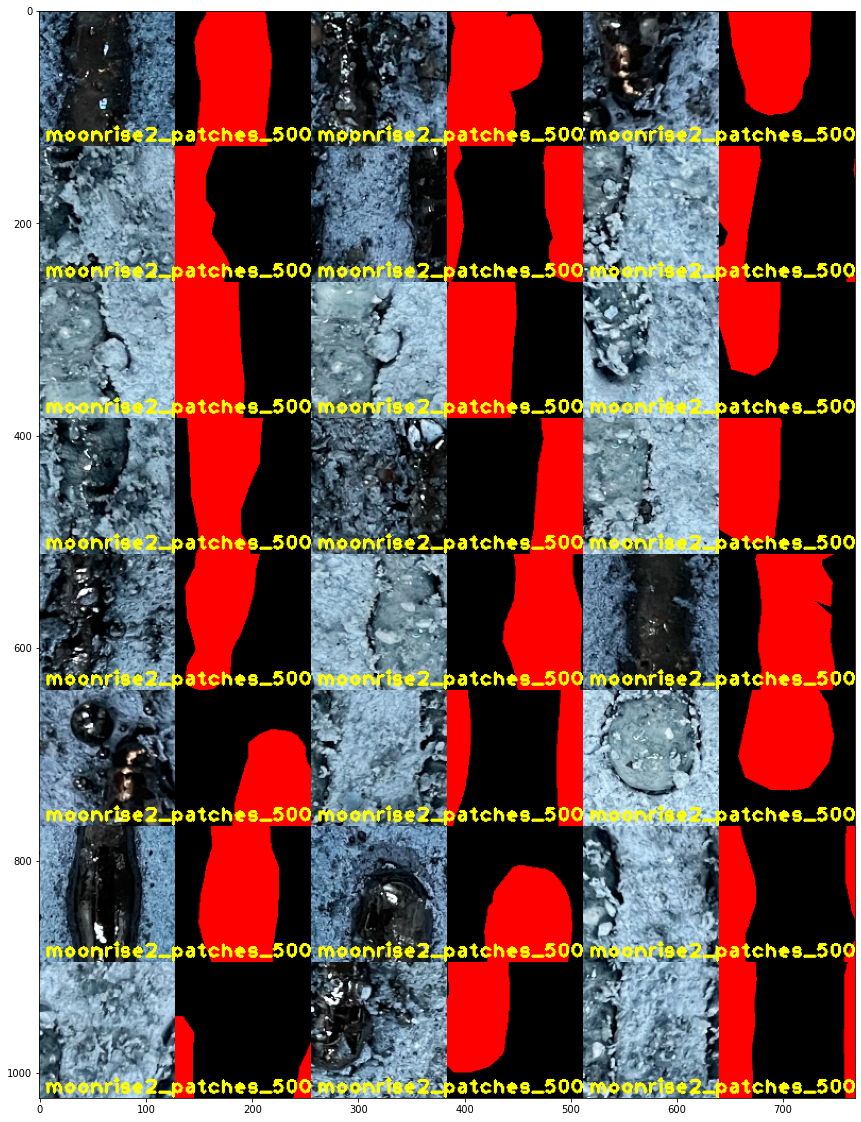

In [11]:
plot_patches(complete_image, tile_size, index=0)

### Test model training iteration

In [12]:
batch_size = 4
val_ratio = 0.2
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4}
train_loader, val_loader =  make_dataloaders(export_dir, val_ratio, params)

In [13]:
it = iter(train_loader)
sample = next(it)
imgs = sample['image']
true_masks = sample['mask']
print(imgs.size())
print(true_masks.size())

torch.Size([4, 4, 500, 500])
torch.Size([4, 500, 500])


In [15]:
net = UNet(n_channels=4, n_classes=1)
# net.cuda()
net.eval()
outputs = net(imgs)

In [16]:
a,b = eval_net_loader(net, val_loader, 3)
print('Class IoU:', ' '.join(f'{x:.3f}' for x in a), f'  |  Mean IoU: {b:.3f}')

Class IoU: 0.594 0.000 nan   |  Mean IoU: 0.297


C:\Users\p.dyroey\Documents\GitHub\Moonrise-AI\notebooks\..\model\eval.py:19: RuntimeWarning: invalid value encountered in divide
  iou = true_positives / denominator


(-0.5, 499.5, 499.5, -0.5)

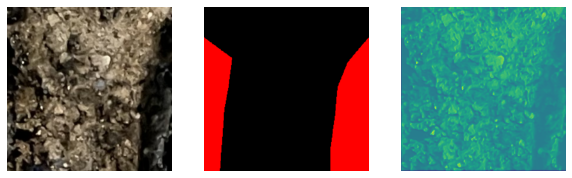

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].imshow(np.transpose(imgs[0], (1,2,0)))
ax[0].axis('off')
ax[1].imshow(mask2rgb(true_masks[0].detach().numpy()))
ax[1].axis('off')
ax[2].imshow(np.transpose(outputs[0].detach().numpy(),(1,2,0)))
ax[2].axis('off')